# Test NPC detection (mature = NPC vs intermediate = PI)

Here we want to:
- use predefined functions to preprocess images (smooth, remove out-of-focus areas)
- define detection thresholds for POM121 and mAb414 channels
- find POM121 and mAB414 (for POM121, it is important to detect the center of the ring => refine minpeakdist)
- sort out PIs and NPCs
- visualize results

I will use this Jupyter notebook to optimize paramaters. Then I will define functions to treat all images.

## Table of content:
* [Import libraries](#libraries)
* [Pre-process images](#pre-processing)
* [Detect peaks](#detect)
* [Sort pore types](#sorting)
* [Visualize resuts](#results)



---

## Import libraries <a class="anchor" id="libraries"></a>



In [1]:
# Import packages
import os
import glob
#import json
from tkinter.filedialog import askdirectory
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from skimage import morphology
from skimage.feature import peak_local_max
import skimage.filters as skfilt
from scipy import ndimage as ndi
from scipy import ndimage
import skimage.filters
from skimage.filters import threshold_otsu
import plotly.express as px
#from findmaxima2d import find_maxima, find_local_maxima 


from clustersize import cluster_size
from findmaxima import find_maxima
from binarycellmap import binary_cell_map
from iterative_functions import lorentzian, gaussian, iterative_fit
from nucmask import nucleus_mask, nucleus_focus_mask
from process import process


---

## Pre-process images <a class="anchor" id="pre-processing"></a>


/Users/christine/Documents/Data/STED/Data_for_analysis/SampleTest
now = 2023-02-13 10:32:32.782438
date and time = 20230213_10:32
/Users/christine/Documents/Data/STED/Data_for_analysis/Results/20230213_10:32
200812_siNup53-2
px size=  14.999999925000001


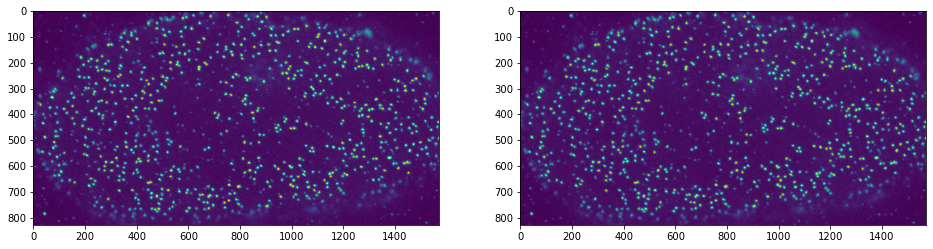

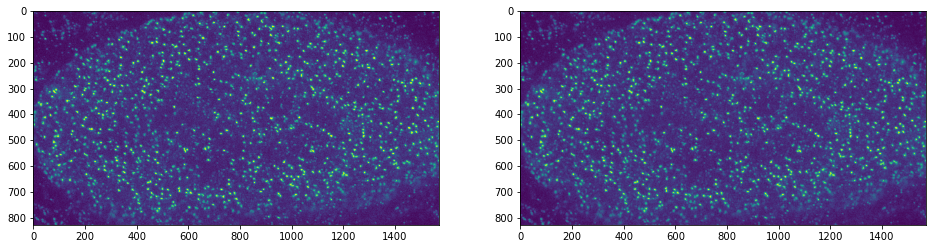

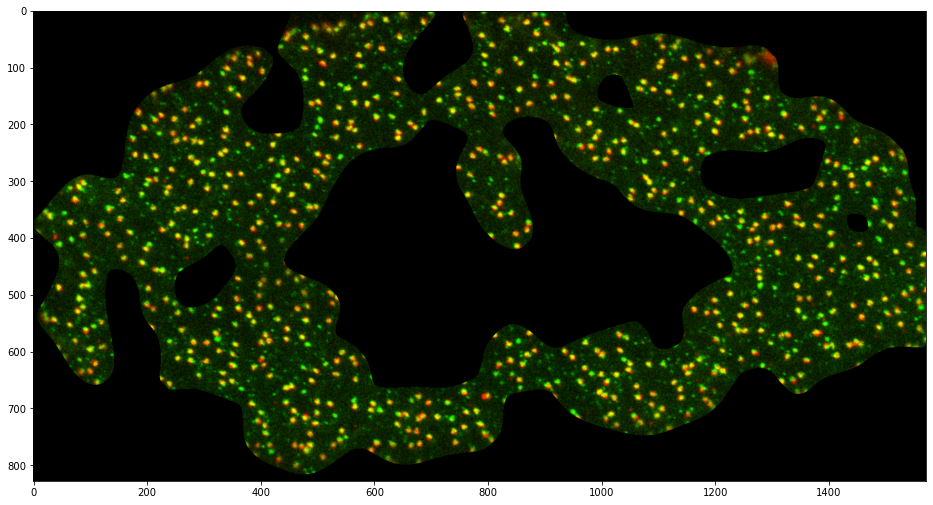

In [2]:
import os

## Load data and parameters 
#Choose the data folder
dirpath = askdirectory(title='Choose your data folder...',initialdir='/Users/christine/Documents/Data/STED/')  # directory path
print(dirpath)
outputfolder = askdirectory(title='Choose the folder to save your results...',initialdir='/Users/christine/Documents/Data/STED/')

## Set the date
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
date = now.strftime("%Y%m%d_%H:%M")
print("date and time =", date)	
outputpath = outputfolder+'/'+date
print(outputpath)
os.mkdir(outputpath)

## Define parameter constants

#difgaus_sigmahi_nm = 100  # difference of gaussians high_sigma in nm
sm_size_nm = 30  # Gaussian size in nm for pore detection
gf_nm = 10 # Gaussian size in nm for denoising
gaussstd_nm = 500 # size of the low-pass filter for removal of out-of-focus areas and deblurring


minpeakdist = 40  # minimum distance between peaks in nm for peak detection 


## Choose to analyze the whole set of data or just one
allimgs = False  # parameter to check if you want to loop through all imgs or just analyse one


## Load images paths
if allimgs:
    files = glob.glob(os.path.join(dirpath, '*[0-9].tif'))
    
else:
    files = [os.path.join(dirpath, '200812_siNup53-2.tif')]



######################################################################################################################

pores = [] 

## Extract image names from paths
for filepath in files:
    imgname = filepath.split('/')[-1].split('.')[0]
    print(imgname)
    condition = imgname.split('_')[-1].split('-')[0]
    
    # Load raw image file and read pixel size from metadata
    mABpath = os.path.join(dirpath, imgname+'.msr_414.tif')
    POMpath = os.path.join(dirpath, imgname+'.msr_POM.tif')
    
    
    with tifffile.TiffFile(mABpath) as tif:
        mABraw = tif.pages[0].asarray()  # image as numpy array
        pxs_nm = 1e9/tif.pages[0].tags['XResolution'].value[0]  # pixel size in nm
        print('px size= ',pxs_nm)
        
    with tifffile.TiffFile(POMpath) as tif:
        POMraw = tif.pages[0].asarray()  # image as numpy array
        #print(POMraw.shape)
        
######################################################################################################################
## Pre-process images 
    
    mAB = process(mABraw, gf_nm, pxs_nm)
    
    fig,(ax0,ax1) = plt.subplots(nrows=1,ncols=2,figsize=(16,16))
    ax0.imshow(mABraw)
    ax1.imshow(mAB)
    
    POM = process(POMraw, gf_nm, pxs_nm)
    
    fig,(ax2,ax3) = plt.subplots(nrows=1,ncols=2,figsize=(16,16))
    ax2.imshow(POMraw)
    ax3.imshow(POM)

    
## Get binary mask
    mask = nucleus_focus_mask(mAB, gaussstd_nm=500, pxs_nm=15, num_di=12, num_er=5)
    
    B = np.zeros(mAB.shape)
    RGB0 = np.dstack((mAB,POM,B))
    POMimg = POM*mask
    mABimg = mAB*mask
    RGB1 = np.dstack((mABimg,POMimg,B))

    fig,ax4 = plt.subplots(figsize=(16,16))
    ax4.imshow(RGB0)
    
    fig,ax5 = plt.subplots(figsize=(16,16))
    ax5.imshow(RGB1)
    

 
   
    





---

## Detect peaks <a class="anchor" id="detect"></a>


/Users/christine/Documents/Git/STED_PI_sizes/findmaxima.py:16: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  is_peak = peak_local_max(img, min_distance=min_dist, threshold_abs=thresh_abs, num_peaks_per_label=1, indices=False)


(677, 2)
(1256, 2)


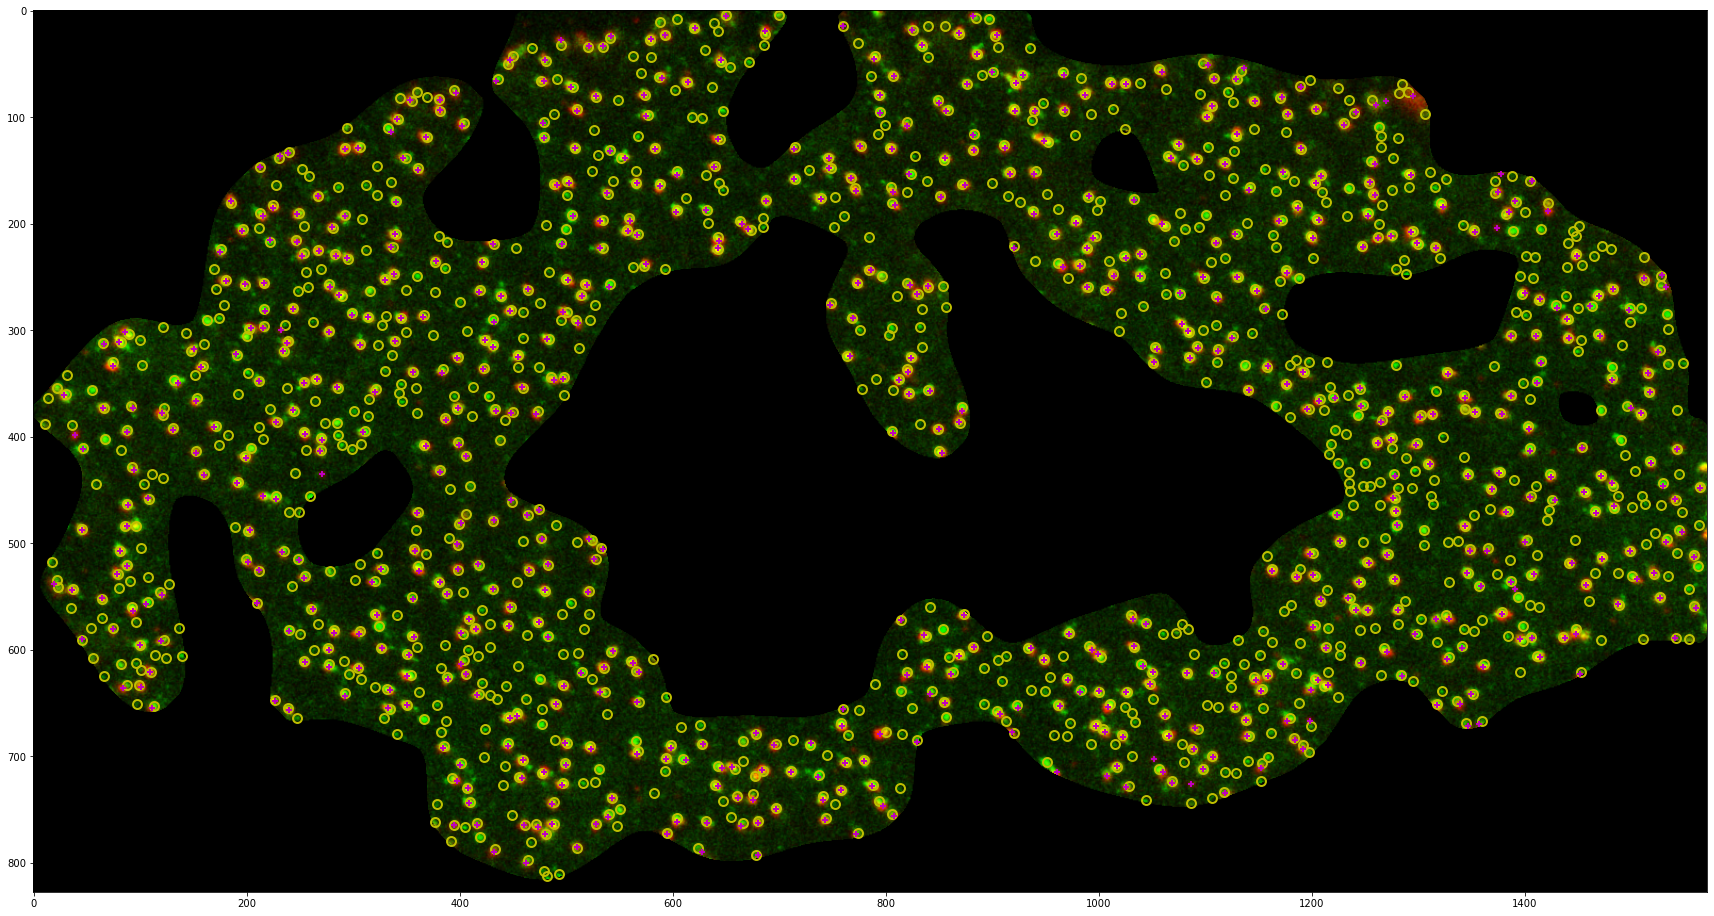

In [3]:
######################################################################################################################
## Detect pore intermediates
sm_size_nm = 30

## Determine thresholds with otsu method
ThPOM = threshold_otsu(POMimg)-0.5*np.std(POMimg)  
ThmAB = threshold_otsu(mABimg)-0.5*np.std(mABimg)

## Build RGB image for visual verification

## Detect POM and mAB peaks
POMfilt = ndimage.gaussian_filter(POMimg,sm_size_nm/pxs_nm)
mABfilt = ndimage.gaussian_filter(mABimg,sm_size_nm/pxs_nm)

RGB2 = np.dstack((mABfilt,POMfilt,B))
fig, ax = plt.subplots(figsize=(30,30))
plt.imshow(RGB1)

POM_peaks = find_maxima(POMfilt, thresh_abs=ThPOM, min_dist=round(minpeakdist/pxs_nm))
mAB_peaks = find_maxima(mABfilt, thresh_abs=ThmAB, min_dist=round(minpeakdist/pxs_nm))
ax.scatter(POM_peaks[:, 1], POM_peaks[:, 0], s=80,c='#FF000000',marker='o',edgecolors='y',linewidths=2)
ax.scatter(mAB_peaks[:, 1], mAB_peaks[:, 0], s=30,c='m', marker='+',linewidths=2)

plt.savefig(outputpath+'/'+imgname+'_POM_mAB_peaks.tif',dpi=600)

print(mAB_peaks.shape)
print(POM_peaks.shape)


[[649.59445584 791.82025763 699.63814984 ... 479.29258086 492.37131864
  482.28220825]
 [  4.05194897   2.70391593   4.25992773 ... 808.4147119  810.09101325
  811.98027302]]


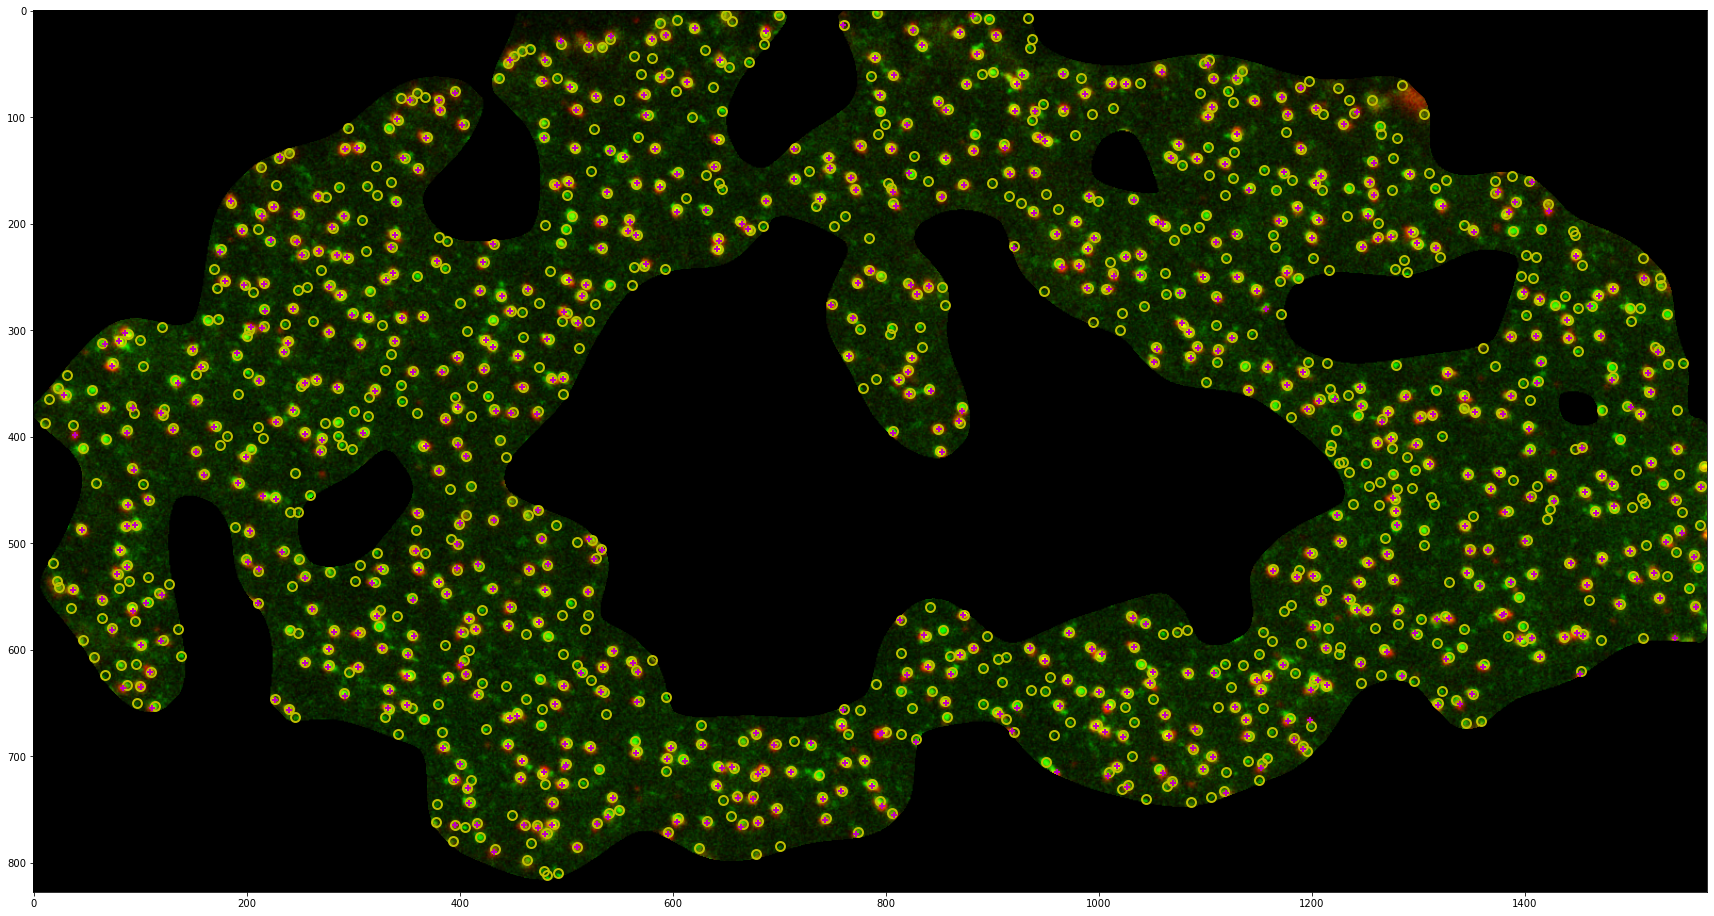

In [5]:
from detect import detect_pores

POMpeaks = detect_pores(POMfilt, threshold=ThPOM, fwhm=120/pxs_nm)
mABpeaks = detect_pores(mABfilt, ThmAB, fwhm=90/pxs_nm)
print(POMpeaks)

fig, ax = plt.subplots(figsize=(30,30))
plt.imshow(RGB1)
ax.scatter(POMpeaks[0,:], POMpeaks[1,:], s=80,c='#FF000000',marker='o',edgecolors='y',linewidths=2)
ax.scatter(mABpeaks[0,:], mABpeaks[1,:], s=30,c='m', marker='+',linewidths=2)







---

## Sort pores <a class="anchor" id="sorting"></a>


In [40]:
## try knn search to find POM's nearest neighbour within mAB. 
## if distance > 40nm, POM peak is a PI => cyan circle 
## NPC = mAB => magenta circle

from scipy import spatial


dist = 40/pxs_nm

def sort_pores(POMpeaks, mABpeaks, dist):
    
    
    
    return NPC, PI



[[  4. 761.]
 [  5. 650.]
 [  5. 882.]
 ...
 [790. 627.]
 [793. 680.]
 [800. 462.]]


---

## Visualize results <a class="anchor" id="results"></a>
